In [1]:
import numpy as np
import gensim
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
%matplotlib inline


In [2]:
np.__version__

'1.18.5'

In [3]:
gensim.__version__

'3.8.1'

Let's load pretrained bert token vectors and project them to 2d space using tSNE.

# Load data

# bert model and tokenizer

In [4]:
embedding_type = 4 # 1 for static word embedding and 2 for dynamic token embedding

### bert model
## distiluse bert 
from sentence_transformers import SentenceTransformer
embedder = SentenceTransformer('bert-base-nli-mean-tokens')#'distiluse-base-multilingual-cased')

sentences = ['This framework generates embeddings for each input sentence',
    'Sentences are passed as a list of string.', 
    'The quick brown fox jumps over the lazy dog.']
embeddings = embedder.encode(sentences, output_value = 'token_embeddings')


### bert tokenizer
## 1 distiluse bert tokenizer
from transformers import DistilBertTokenizer
tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased")
tokenizer._cased = True

## 2 distiluse bert tokenizer
from bert_tokenizer import BertTokenizer
tokenizer = BertTokenizer.load_from_vocab_file('/home/dxwang/data/distil_cased_based/vocab.txt')
tokenizer._cased = True
print(tokenizer.tokenize('männern'))
# https://github.com/RaRe-Technologies/gensim/blob/fff82aa06b1cddf08906cae8c5a98e676f233814/gensim/models/keyedvectors.py#L377

## 3. distiluse bert tokenizer
embedder.tokenize('männern')

## 4 multi-bert tokenizer
multi_bert_tokenizer = BertTokenizer.load_from_vocab_file('/home/dxwang/data/multi_cased_L-12_H-768_A-12/vocab.txt')
multi_bert_tokenizer._cased = True


/home/dxwang/anaconda3/envs/pytorch/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/dxwang/anaconda3/envs/pytorch/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/dxwang/anaconda3/envs/pytorch/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/dxwang/anaconda3/envs/pytorch/lib/pyt

['män', '##nern']


AttributeError: 'BERT' object has no attribute 'tokenize_to_token'

# word embedding

In [ ]:
### static embedding key: value pairs
f = "bert-base-uncased.30522.768d.vec"
# f = 'bert-base-cased.28996.768d.vec'
# f = 'bert-base-multilingual-uncased.105879.768d.vec'
# f = 'bert-base-chinese.21128.768d.vec'
f = 'bert-base-multilingual-cased.119547.768d.vec'
# f = 'bert-base-uncased.30522.768d.vec'
# f = 'bert-large-cased.28996.1024d.vec'
# from transformer import BertTokenizer
model = gensim.models.KeyedVectors.load_word2vec_format(f, binary=False)


In [7]:
def get_tokenized_tokens(string, embedding_type):
    if embedding_type == 1: en_temp = [string]
    elif embedding_type == 2: en_temp = tokenizer.tokenize(string)
    else: en_temp = multi_bert_tokenizer.tokenize(string)
    return en_temp



def get_embedding(string : str, embedding_type=1):
    if embedding_type == 1:   # seq_len * embed_dim
        return [model[w] for w in tokenizer.tokenize(string)]
    elif embedding_type == 2: # seq_len * embed_dim
        return [(embedder.encode(w, output_value = 'token_embeddings')[0]).mean(axis=0) for w in string.split()][:len(string.split())]
        return [(embedder.encode(w, output_value = 'token_embeddings')[0][1:-1]).mean(axis=0) for w in string.split()]
    elif embedding_type == 3: # seq_len * embed_dim
        return embedder.encode(string, output_value = 'token_embeddings')[0][1:-1]
    elif embedding_type == 4: # seq_len * embed_dim
        return embedder.encode(string, output_value = 'token_embeddings')[0][1:-1].mean(axis=0)
    elif embedding_type == 5: # seq_len * embed_dim
        embs = []
        for w in string.split():
            emb, sub_ws = 0., tokenizer.tokenize(w)
            for sub_w in sub_ws: emb += (embedder.encode(sub_w, output_value = 'token_embeddings')[0][1:-1]).mean(axis=0)
            embs.append(emb/float(len(sub_ws)))
        return embs
#         return (embedder.encode(string, output_value = 'token_embeddings')[0]).mean(axis=0)        

In [8]:
### compute alignments
from collections import Counter
from typing import List
def get_alignment(de_raw_sentence: List[str], embedding_type):
    de_alignment = []
    id = 0
    de_raw_tokens = de_raw_sentence.split()
    for word in de_raw_tokens:
        de_alignment.extend([id for _ in range(len(get_tokenized_tokens(word, embedding_type)))])
        id += 1
    print(de_alignment, len(de_alignment))
    assert id == len(de_raw_tokens), (id, len(de_raw_tokens))
    de_alignment_dict = Counter(de_alignment)
    return de_alignment, de_alignment_dict


def cosine_distance(a, b):
    if a.shape != b.shape:
        raise RuntimeError("array {} shape not match {}".format(a.shape, b.shape))
    if a.ndim==1:
        a_norm = np.linalg.norm(a)
        b_norm = np.linalg.norm(b)
    elif a.ndim==2:
        a_norm = np.linalg.norm(a, axis=1, keepdims=True)
        b_norm = np.linalg.norm(b, axis=1, keepdims=True)
    else:
        raise RuntimeError("array dimensions {} not right".format(a.ndim))
    similiarity = np.dot(a, b.T)/(a_norm * b_norm)
    dist = 1. - similiarity
    return dist



def get_aligned_embeddings(de_alignment, de_alignment_dict, de_sentence_embed):
    id, de_emb_average, alignment_de_embeds = 0, 0., []
    
    for i, de_emb in enumerate(de_sentence_embed):
        ### apply alignment
        if de_alignment[i] == id:
            de_emb_average += de_emb
        else:
            de_emb_average /= de_alignment_dict[id]
            alignment_de_embeds.append(de_emb_average)
            id += 1
            de_emb_average = de_emb
    de_emb_average  /= de_alignment_dict[id]
    alignment_de_embeds.append(de_emb_average)
    assert len(alignment_de_embeds) == max(de_alignment)+1, (len(alignment_de_embeds), max(de_alignment)+1)
    return alignment_de_embeds
                        


def compute_word2words_similarity(keys, query, sim_type=1,
                                  norm_similarity=False, k=2, sparse_top_k=False):
    similarity = []
    for i, key in enumerate(de_sentence_embed):
        if sim_type == 1: similarity.append(1-cosine_distance(query, key))
        elif sim_type == 2: similarity.append(np.exp(-np.linalg.norm(query-key, ord=2, axis=-1)))
        else: e
    
    if sparse_top_k:
        top_k_similarity = sorted(similarity, reverse=True)[k-1]
        similarity = [i if i >= top_k_similarity else 0 for i in similarity]
    if norm_similarity:
        similarity = np.array(similarity) / np.array(similarity).sum()
        similarity = similarity.tolist()
    
    return similarity



# object textual embeddings

In [133]:
embedding_type = 4
### get object categories
object_categories = ''

## object COCO-80
# object_categories += '|person|bicycle|car|motorbike|aeroplane|bus|train|truck|boat|traffic|light|fire|hydrant|stop|sign|parking meter'
# object_categories += '|stop sign'
# object_categories += '|bench|bird|cat|dog|horse|sheep|cow|elephant|bear|zebra|giraffe|backpack|umbrella|handbag|tie|suitcase|frisbee'
# object_categories += '|skis|snowboard|sports|ball|kite|baseball|bat|glove|skateboard|surfboard|tennis|racket'
# object_categories += '|bottle|wine|glass|cup|fork|knife|spoon|bowl|banana|apple|sandwich|orange|broccoli|carrot|hot dog'
# object_categories += '|pizza|donut|cake|chair|sofa|pottedplant|bed|diningtable|toilet|tvmonitor|laptop|mouse|remote|keyboard|cellphone'
# object_categories += '|microwave|oven|toaster|sink|refrigerator|book|clock|vase|scissors|teddy|bear|hair|drier|tooth|brush'

## place 365
with open('/home/dxwang/code/places365/IO_places365.txt', 'r') as f: 
    places = '|'.join([p.strip().split()[0].split('/')[-1] for p in f.readlines()])
    places = places.replace('_', ' ')
object_categories += '|'+places

## OpenImage 19,958 classes
with open('openimage-classes.csv', 'r') as f: 
    openimage = '|'.join([p.strip().split(',')[-1] for p in f.readlines()[1:]])
object_categories += openimage

## visual genome attributes
# import json
# with open('attribute_synsets.json', 'r') as f:
#     vs_genome = []
#     for l in f.readlines():
#         vs_genome.extend(json.loads(l).keys())
# vs_genome = '|'.join(vs_genome)
# vs_genome = vs_genome.replace('/', '/')
# vs_genome = vs_genome.replace('.', '.')
# vs_genome = vs_genome.replace('`', ' ')
# vs_genome = vs_genome.replace('—', '-')
# object_categories += '|' + vs_genome


## tab-vcr clean-up attributes and objects
with open('vcr/attributes_vocab.txt', 'r') as f: 
    attributes = '|'.join([p.strip().split(',')[0] for p in f.readlines()])
    attributes = attributes.replace('_', ' ')
object_categories += '|'+attributes

with open('vcr/objects_vocab.txt', 'r') as f: 
    objects = '|'.join([p.strip().split(',')[0] for p in f.readlines()])
    objects = objects.replace('_', ' ')
object_categories += '|'+objects



## clear noisy words
object_categories = object_categories.replace('’', "'")
object_categories = object_categories.replace('–', '-')
object_categories = object_categories.replace("\\", ' ')
object_categories = object_categories.replace('*', ' ')

# object_categories = object_categories.replace(' ', '|')
object_categories = object_categories.split('|')
object_categories = list(set(object_categories))


## get object embeddings
obj_embs = []
for i, obj in enumerate(object_categories):
    if i % 1000 == 0: print(i, ' / ', len(object_categories))
    average_obj_emb = get_embedding(obj, embedding_type=embedding_type)
    obj_embs.append(average_obj_emb)
    
len(obj_embs), obj_embs[0].shape



0  /  22150


/home/dxwang/anaconda3/envs/pytorch/lib/python3.6/site-packages/ipykernel_launcher.py:18: RuntimeWarning: Mean of empty slice.


1000  /  22150
2000  /  22150
3000  /  22150
4000  /  22150
5000  /  22150
6000  /  22150
7000  /  22150
8000  /  22150
9000  /  22150
10000  /  22150
11000  /  22150
12000  /  22150
13000  /  22150
14000  /  22150
15000  /  22150
16000  /  22150
17000  /  22150
18000  /  22150
19000  /  22150
20000  /  22150
21000  /  22150
22000  /  22150


(22150, (768,))

# Read the data

In [190]:
# model.most_similar("look")
source_language = 'en'
target_language = 'fr'

sample_id = 1
en_file, de_file = "test."+source_language, "test."+target_language
with open(en_file, 'r') as f: ens = f.readlines()
with open(de_file, 'r') as f: des = f.readlines()
    
de_raw_sentence = des[sample_id].strip()
en_raw_sentence = ens[sample_id].strip()

en = tokenizer.tokenize(ens[sample_id])
de = tokenizer.tokenize(des[sample_id])
# for s in en:
#     print(model[s])
# for s in de:
#     print(model[s])
print(en)
print(de)


['a', 'black', 'and', 'white', 'photo', 'of', 'a', 'dog', 'stari', '##ng', 'ahead', 'with', 'a', 'background', 'of', 'signs', 'written', 'in', 'asi', '##an', 'language', 'characters', '.']
['une', 'photo', 'en', 'noir', 'et', 'blanc', 'd', '&', 'apo', '##s', ';', 'un', 'chien', 'regard', '##ant', 'droit', 'devant', 'avec', 'un', 'arrière', '-', 'plan', 'de', 'symbole', '##s', 'écrits', 'en', 'caractères', 'asi', '##atique', '##s', '.']


In [191]:
embedding_type = 4

vocab_embs = []
texts = [' '.join([e,d]) for e,d in zip(ens, des)]
texts = ' '.join(texts).split()
texts = dict(Counter(texts)).keys()
print('vocab number of', en_file, 'and', de_file, '=', len(texts))

print('========== preparing vocab embedding table...')
for i, voc in enumerate(texts):
    if i % 1000 == 999:
        print(i, ' / ', len(texts))
    average_vocab_emb = get_embedding(voc, embedding_type=embedding_type)
    vocab_embs.append(average_vocab_emb)
    
print(vocab_embs[0].shape)
print('========== Done.=============================')


print('========== preparing vocab_vi_dict...')
thre = 0.70
similarity_version = 'max'
similarity_total = np.array([0. for i in range(len(vocab_embs))])
for i, obj_emb in enumerate(obj_embs):
    similarity = []
    if i % 1000 == 0: print(i, ' / ', len(obj_embs))
    for average_word_emb in vocab_embs:
        similarity.append(1-cosine_distance(obj_emb, average_word_emb))
    similarity = [similarity[i] if similarity[i]>=thre else 0. for i in range(len(similarity))]
    if similarity_version == 'sum': similarity_total += np.array(similarity)
    if similarity_version == 'max': similarity_total = np.concatenate((similarity_total[:, np.newaxis], np.array(similarity)[:, np.newaxis]),
                                                                         axis=-1).max(axis=-1)
vocab_vi_dict = dict((key, value) for key, value in zip(texts, similarity_total))

print('========== Written into', vocab_vi_dict_file, '...')
vocab_vi_dict_file = de_file+'.vocab_vi_dict.txt'
with open(vocab_vi_dict_file, 'w') as f:
    for key, value in vocab_vi_dict.items():
        f.write(key)
        f.write(' ')
        f.write(str(value))
        f.write('\n')
print('========== Written into', vocab_vi_dict_file, 'Done.=============================')


vocab number of test.en and test.fr = 3506
========== preparing vocab embedding table...
999  /  3506
1999  /  3506
2999  /  3506
(768,)
========== Done.=============================
========== preparing vocab_vi_dict...
0  /  22150
1000  /  22150
2000  /  22150
3000  /  22150
4000  /  22150
5000  /  22150
6000  /  22150
7000  /  22150
8000  /  22150
9000  /  22150
10000  /  22150
11000  /  22150
12000  /  22150
13000  /  22150
14000  /  22150
15000  /  22150
16000  /  22150
17000  /  22150
18000  /  22150
19000  /  22150
20000  /  22150
21000  /  22150
22000  /  22150
========== Written into valid.fr.vocab_vi_dict.txt ...
========== Written into test.fr.vocab_vi_dict.txt Done.=============================


In [192]:
with open(vocab_vi_dict_file, 'r') as f: vocab_vi = f.readlines()
texts = [line.split()[0] for line in vocab_vi]
similarity_total = [float(line.split()[1]) for line in vocab_vi]
vocab_vi_dict = dict((key, value) for key, value in zip(texts, similarity_total))


# select all object-linguistic-relevant tokens

In [193]:

def get_similar_object_in_sentence(en_raw_sentence, verbose=False, thre=0.70, similarity_version='max', prepared_vi_dict=vocab_vi_dict):
    en_tokens = en_raw_sentence.split()
    
    if prepared_vi_dict is not None:
        similarity_total = [prepared_vi_dict[w] for w in en_raw_sentence.split()]
    else:
        ## get word embedding
        word_embs = [get_embedding(w, embedding_type) for w in en_raw_sentence.split()]

        ## calculate similarity with object categories
        similarity_total = np.array([0. for i in range(len(word_embs))])
        for i, obj_emb in enumerate(obj_embs):
            similarity = []
            for average_word_emb in word_embs:
                similarity.append(1-cosine_distance(obj_emb, average_word_emb))

            if verbose: print('====================', object_categories[i], '================')

            similarity = [similarity[i] if similarity[i]>=thre else 0. for i in range(len(similarity))]
            if similarity_version == 'sum': similarity_total += np.array(similarity)
            if similarity_version == 'max': similarity_total = np.concatenate((similarity_total[:, np.newaxis], np.array(similarity)[:, np.newaxis]),
                                                                             axis=-1).max(axis=-1)

            if verbose:
                for i in range(len(en_tokens)): 
                    if similarity[i]>=thre: print(en_tokens[i], '\t', similarity[i])

    # similarity_total /= len(obj_embs)
    if verbose:
        print('========= VTCD to source sentence WVI: ', en_raw_sentence, '==============')
        for i in range(len(en_tokens)): print(en_tokens[i], '\t', similarity_total[i])
    return similarity_total

embedding_type = 4

obj_to_en_similarities, en_tokens = [], []
for i, en_raw_sentence in enumerate(ens):
    if i % 1000 == 0: print(i, i/len(ens)*100., '%')
    obj_to_en_similarities.append(get_similar_object_in_sentence(en_raw_sentence.strip()))
    en_tokens.append(en_raw_sentence.split())


0 0.0 %


In [194]:
en2obj_file = en_file+'.obj2'+source_language
with open(en2obj_file, 'w') as f:
    for sims in obj_to_en_similarities:
        sims = [str(round(s, 2)) for s in sims]
        f.write(' '.join(sims)+'\n')


In [195]:
en2obj_file = en_file+'.obj2'+source_language
with open(en2obj_file, 'r') as f: obj_to_en_similarities = f.readlines()
obj_to_en_similarities = [[float(n) for n in line.split()] for line in obj_to_en_similarities]


# draw sentence-level bert embedding similarity

# Find most related tokens

In [196]:

def tsne(query, topn=10, results=None, wordvectors=None):

    if results is None:
        results = model.wv.similar_by_word(query, topn=topn)
        results = results[:100]
        words = [query]+[r[0] for r in results]
    else:
        words = [query]+ results

    if wordvectors is None:
        wordvectors = np.array(model[query]+[model[w] for w in words], np.float32)

        
    reduced = TSNE(n_components=2).fit_transform(wordvectors)
    plt.figure(figsize=(20, 20), dpi=100)
    max_x = np.amax(reduced, axis=0)[0]
    max_y = np.amax(reduced, axis=0)[1]
    plt.xlim((-max_x, max_x))
    plt.ylim((-max_y, max_y))
    plt.scatter(reduced[:, 0], reduced[:, 1], s=70, c=["r"] + ["b"]*(len(reduced)-1))
    
    for i in range(len(words)):
        target_word = words[i]
        # print(target_word)
        x = reduced[i, 0]
        y = reduced[i, 1]
        plt.text(x, y, target_word, family='fantasy', fontsize=24)
    plt.axis('off')

    plt.show()




In [197]:
arg = 3



In [198]:
def calculate_vocab_dict(files=['train.'+target_language, 'valid.'+target_language]):
    strings = []
    for file in files:
        with open(file, 'r') as f: strings.extend([line.strip() for line in f.readlines()])
    tokens = []
    for string in strings: tokens.extend(string.split())
    vocab_dict = dict(Counter(tokens))
    for key in vocab_dict.keys():
        vocab_dict[key] /= len(tokens)
    return vocab_dict
vocab_de_dict = calculate_vocab_dict()


In [199]:
embedding_type, align_similairty = 3, False
if embedding_type == 3: align_similairty = True

thre = 0.1
sim_type = 1 # 1 or 2
similarity_version = 'max'
en_to_de_similarities = []


for arg, (de_raw_sentence, en_raw_sentence, otsims) in enumerate(zip(des, ens, obj_to_en_similarities)):
    
    de_sentence_embed = get_embedding(de_raw_sentence, embedding_type)
    en_sentence_embed = get_embedding(en_raw_sentence, embedding_type)
    de = tokenizer.tokenize(de_raw_sentence)
    en = tokenizer.tokenize(en_raw_sentence)

    similarity_total = None
    en_token_use_num = 0.

    if embedding_type == 3:
        de_alignment, de_alignment_dict = get_alignment(de_raw_sentence, embedding_type)
        if align_similairty:
            keys = de_sentence_embed
        else:
            keys = get_aligned_embeddings(de_alignment, de_alignment_dict, de_sentence_embed)
    else: 
        de_alignment = [i for i in range(len(de_raw_sentence.split()))]
        de_alignment_dict = Counter(de_alignment)
        keys = de_sentence_embed
            
    for txt, query, otsim in zip(en, en_sentence_embed, otsims):
        if otsim <= 0.1: continue
        if txt in ['a', 'and', '.', ',', 'the']: continue
        en_token_use_num += 1.
        
        similarity = compute_word2words_similarity(keys, query, sim_type=sim_type)
        similarity = [s if s>=thre else 0 for s in similarity]
        
        if align_similairty:
            new_similarity = []
            for id in range(max(de_alignment)+1):
                similarity_temp = [similarity[i] for i, a in enumerate(de_alignment) if a == id]
                new_similarity.append(max(similarity_temp))
            similarity = new_similarity
        
        # print('\n============== The word to match: ', txt, '======================')
        # for a, b in zip(de_raw_sentence.split(), similarity):
        #     print(a, '\t',  b)
        
        
        ## 1
        similarity = [s*otsim for s, w in zip(similarity, de_raw_sentence.split())]
        
        ## 2
        similarity = [s*otsim/(vocab_de_dict[w]+1e-6) if w in vocab_de_dict
                      else 0. # oov
                      for s, w in zip(similarity, de_raw_sentence.split())]
        similarity = [s/(sum(similarity)+1e-6) for s in similarity]
        
        if similarity_total is None: similarity_total = np.array(similarity)
        else:
            if similarity_version == 'sum': similarity_total += np.array(similarity)
            if similarity_version == 'max': similarity_total = np.concatenate((similarity_total[:, np.newaxis], 
                                                                               np.array(similarity)[:, np.newaxis]),
                                                                             axis=-1).max(axis=-1)

        ## tsne
        alignment_sentence_embeds = [query]
        alignment_sentence_embeds.extend(keys)
        # tsne(txt, None, de_raw_sentence.split(), wordvectors=alignment_sentence_embeds)

    if similarity_total is None: similarity_total = np.array([0 for _ in range(len(de_raw_sentence.split()))])
    if similarity_version == 'sum': similarity_total /= en_token_use_num
    
    if arg % 1000 == 0:
        print('\n============== The sentence pair ======================')
        print('src sentence:', en_raw_sentence.strip())
        print('tgt sentence:', de_raw_sentence.strip())
        print()
        for a, b in zip(de_raw_sentence.split(), similarity_total.tolist()):
            print(a, '\t',  b)
    assert len(similarity_total.tolist()) == len(de_raw_sentence.split()), (len(similarity_total.tolist()), len(de_raw_sentence.split()))
    en_to_de_similarities.append(similarity_total.tolist())
print('============== Done ================')

[0, 1, 2, 3, 4, 4, 5, 5, 6, 7, 8, 9, 10, 11, 12, 13, 13, 13, 13, 13, 14, 15, 16, 16, 16, 16, 16, 17] 28

============== The sentence pair ======================
src sentence: a sleek yellow dog mid run on a dirt area on an obstacle course
tgt sentence: un chien jaune au poil soyeux court sur une piste en terre lors d&apos; une course d&apos; obstacles

un 	 0.0002762541777247761
chien 	 0.007227287614962814
jaune 	 0.017757707603252897
au 	 0.004324568440477806
poil 	 0.2779319874482758
soyeux 	 0.5681820865204853
court 	 0.010716178254554525
sur 	 0.0008247320928429756
une 	 0.00032542394895533063
piste 	 0.0313001257530207
en 	 0.0007408009486886181
terre 	 0.023583668350780716
lors 	 0.009785790722616266
d&apos; 	 0.0007395334272212618
une 	 0.00033897037436685204
course 	 0.01620367195111476
d&apos; 	 0.0007046936674206844
obstacles 	 0.31704976310189387
[0, 1, 2, 3, 4, 5, 6, 6, 6, 6, 6, 7, 8, 9, 9, 10, 11, 12, 13, 14, 14, 14, 15, 16, 16, 17, 18, 19, 20, 20, 20, 21] 32
[0, 1, 2, 3,

[0, 1, 2, 2, 3, 4, 5, 5, 5, 5, 5, 6, 7, 8, 9, 9, 9, 10] 18
[0, 1, 1, 1, 2, 3, 4] 7
[0, 1, 1, 2, 3, 4, 5, 5, 6, 6, 7, 8, 9, 10] 14
[0, 1, 2, 3, 4, 4, 4, 5, 6, 6, 7, 8] 12
[0, 1, 2, 3, 3, 4, 4, 4, 4, 4, 5, 6, 7, 7, 8, 9, 10, 11, 12, 13, 13, 13, 14, 15] 24
[0, 1, 2, 3, 4, 5, 5, 5, 6, 7, 8, 9, 10, 11, 12, 12, 13, 14, 15] 19
[0, 1, 2, 3, 4, 5, 5, 5, 5, 5, 6, 6, 7, 8, 9, 10, 11, 11, 12, 13, 14, 15, 16, 17] 24
[0, 1, 2, 3, 4, 5, 6, 6, 6, 7, 8, 9, 9, 9, 10, 10, 10, 11, 12, 13, 13, 13, 13, 14] 24
[0, 1, 2, 3, 4, 5, 6, 6, 6, 7, 8, 9, 9, 10, 10, 10, 11] 17
[0, 1, 2, 3, 4, 4, 5, 6, 6, 7, 8, 9, 10, 10, 11, 12, 13, 14, 14, 15, 16, 17, 17, 18, 19, 19, 20, 21, 22, 23] 30
[0, 1, 2, 3, 3, 3, 4, 4, 4, 4, 4, 5, 5, 5, 5, 6, 7, 8, 8, 8, 8, 8, 9, 10, 11, 11, 11, 12, 13, 13, 14, 15, 15, 16, 17, 18, 19] 37
[0, 1, 2, 3, 4, 5, 5, 6, 7, 8, 8, 9, 10, 11] 14
[0, 1, 2, 3, 4, 4, 5, 6, 6, 7, 8, 8, 8, 8, 8, 9, 10, 11, 12, 13, 13, 14, 15, 16, 17, 17, 17, 18] 28
[0, 0, 0, 0, 0, 1, 2, 3, 4, 4, 4, 5] 12
[0, 1, 2, 2, 2, 3, 

[0, 1, 2, 3, 4, 5, 6, 7, 8] 9
[0, 1, 2, 3, 4, 5, 5, 6, 7, 8, 9, 9, 9, 9] 14
[0, 1, 2, 3, 4, 4, 5, 6, 7, 8, 9, 10, 11, 12, 12, 13, 14, 15, 16, 17] 20
[0, 1, 1, 1, 2, 3, 4, 4, 5, 6, 7, 8, 9, 10, 10, 10, 11] 17
[0, 1, 2, 3, 4, 5, 6, 6, 6, 6, 6, 7, 8, 9, 10, 11, 11, 12, 13, 14, 15, 15, 15, 15, 15, 16, 17, 17, 18] 29
[0, 1, 2, 3, 3, 4, 5, 6, 6, 6, 6, 6, 7, 8, 9, 10, 11, 12, 13, 13, 14, 15, 15, 15, 16] 25
[0, 1, 2, 3, 4, 5, 6, 7, 7, 8, 9, 10, 11, 11, 11, 12, 13, 14, 14, 15, 15, 16] 22
[0, 1, 2, 2, 3, 4, 5, 6, 7, 8, 9, 9, 10, 11, 12, 13, 14, 14, 14, 14, 15, 16, 17, 17, 17, 18] 26
[0, 1, 1, 2, 2, 2, 2, 2, 3, 3, 3, 4, 5, 6, 6, 7, 8, 9, 9, 9, 10, 11, 11, 12] 24
[0, 1, 2, 3, 4, 5, 6, 7, 8] 9
[0, 1, 2, 3, 4, 5, 6, 7, 8] 9
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9] 10
[0, 1, 2, 3, 4, 5, 6, 6, 6, 6, 6, 7, 8, 9, 10, 11] 16
[0, 1, 2, 3, 4, 5, 6, 7, 7, 8, 8] 11
[0, 1, 2, 3, 4, 5, 6, 6, 6, 7] 10
[0, 1, 2, 2, 3, 3, 4, 5, 6, 6, 6, 7, 8, 9, 9, 9, 9, 9, 10, 11, 12] 21
[0, 1, 1, 2, 3, 4, 5, 5, 5, 6, 6, 6, 6, 6, 7, 8, 9,

[0, 1, 2, 2, 3, 4, 4, 5, 6, 7, 7, 8, 9, 10, 10, 11, 12] 17
[0, 1, 2, 3, 4, 5, 5, 6, 7, 8, 8, 9, 9, 9, 9, 10, 11, 12, 12, 12, 13, 14, 14, 14, 14, 14, 15, 16, 17, 17, 17, 17, 17, 18, 18, 18, 19, 20, 20, 21] 40
[0, 1, 2, 2, 2, 3, 4, 5, 5, 5, 6, 7, 8, 9] 14
[0, 1, 2, 3, 4, 5, 6, 6, 7, 8, 8, 8, 9, 10, 10, 11, 11, 11, 11, 11, 12, 13, 14] 23
[0, 1, 2, 3, 4, 5, 6, 7, 7, 7, 8, 9, 10, 10, 11, 11, 11, 11, 11, 12, 13, 14] 22
[0, 1, 2, 3, 4, 5] 6
[0, 1, 2, 3, 4, 5, 6, 6, 7, 7, 7, 7, 7, 8, 9, 9, 9, 9, 10, 11, 11, 12, 13, 13, 13, 14] 26
[0, 1, 2, 3, 4, 5, 6, 6, 7, 8, 9, 10, 11, 12, 13, 13, 13, 13, 14, 14, 15, 16, 16, 16, 17] 25
[0, 1, 2, 3, 4, 5, 5, 6, 7, 8, 8, 9, 10, 10, 10, 11] 16
[0, 1, 2, 2, 3, 4, 5, 5, 6, 7, 7, 7, 7, 7, 8, 9, 10, 11, 11, 12, 12, 12, 12, 12, 13, 14, 15, 15, 15, 16] 30
[0, 1, 2, 3, 3, 4, 5, 5, 5, 5, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 16, 16, 17] 25
[0, 1, 2, 2, 2, 2, 2, 3, 4, 5, 6, 7, 8, 9, 10, 10, 10, 11] 18
[0, 1, 2, 3, 3, 3, 3, 4, 5, 5, 6, 6, 6, 7, 8, 9, 10, 11] 18
[0, 

[0, 1, 2, 3, 4, 5, 6, 7, 7, 7, 7, 7, 8, 9, 10, 11, 11] 17
[0, 1, 2, 3, 4, 5, 5, 5, 6, 7, 8, 8, 8, 9, 9, 9, 9, 9, 10, 11, 12, 12, 12, 12, 12, 13, 13] 27
[0, 1, 1, 2, 3, 4, 5, 6, 6] 9
[0, 1, 1, 2, 2, 2, 3, 4, 5, 6, 7, 8, 9, 9, 10, 10, 10, 10, 10, 11, 11, 11, 12, 13] 24
[0, 1, 2, 3, 3, 4, 5, 6, 7, 8, 9, 10] 12
[0, 1, 2, 3, 4, 5, 6, 6, 6, 7, 8, 9] 12
[0, 1, 2, 3, 4, 5, 6, 7, 8, 8, 8, 8, 8, 9, 9, 9, 9, 10, 11, 11, 12, 13, 14, 14, 15] 25
[0, 1, 1, 1, 2, 3, 4, 4, 5, 6, 7, 8, 9, 10, 11, 11, 12, 13] 18
[0, 1, 2, 3, 3, 4, 5, 6, 6, 7, 8, 8, 8, 9] 14
[0, 1, 2, 2, 3, 4, 5, 5, 5, 6, 6, 7] 12
[0, 1, 2, 2, 2, 3, 4, 5, 6, 7, 8, 9] 12
[0, 1, 1, 1, 2, 3, 4, 5, 5, 6, 7, 7, 8, 9] 14
[0, 1, 2, 2, 3, 4, 5, 6, 7, 8, 8, 8, 9, 10, 10, 10, 11] 17
[0, 1, 2, 2, 2, 2, 2, 3, 3, 3, 4, 5, 5, 6, 6, 7, 8, 8, 8, 9, 9, 9, 9, 9, 10, 11, 11, 12] 28
[0, 1, 1, 2, 3, 4, 5] 7
[0, 1, 2, 3, 4, 4, 5, 6, 6, 6, 6, 7, 8, 9, 9, 10, 10, 10, 11, 12, 13, 13, 13, 13, 13, 14, 15, 16, 16, 16] 30
[0, 1, 2, 3, 4, 4, 5, 6, 7] 9
[0, 1, 2, 3, 4,

[0, 1, 2, 3, 3, 3, 3, 3, 4, 5, 6, 7, 8, 9, 10, 10, 11, 11, 12] 19
[0, 1, 2, 3, 4, 5, 6, 7, 7, 7, 8, 9, 10] 13
[0, 1, 2, 3, 4, 5, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14] 16
[0, 1, 2, 3, 4, 5, 5, 5] 8
[0, 1, 2, 3, 4, 5, 5, 6, 7, 8, 9, 9, 10, 11, 12, 12, 12, 13, 14] 19
[0, 1, 1, 2, 3, 3, 3, 4, 5, 5, 5, 6, 7, 8, 9, 10, 11, 12] 18
[0, 1, 2, 3, 4, 5, 6, 6, 7] 9
[0, 1, 1, 1, 2, 3, 4, 5, 5, 5, 6, 6, 7, 7, 7, 8, 9, 10, 11, 11, 12, 13, 13, 14] 24
[0, 1, 1, 2, 3, 4, 4, 5, 5, 5, 5, 5, 6, 6, 6, 7, 8, 8, 8, 8, 8, 9, 10, 11, 11, 11, 11, 11, 12, 13] 30
[0, 1, 1, 1, 2, 2, 3, 4, 5, 6, 7, 8, 9, 9, 10] 15
[0, 1, 2, 3, 4, 5, 6, 7, 8, 8, 8, 8, 8, 9, 10, 11, 12, 13, 14, 15, 15, 15, 16, 17, 17, 18] 26
[0, 1, 1, 2, 2, 2, 3, 3, 3, 3, 3, 4, 5, 6, 7, 8, 8, 8, 8, 8, 9, 10] 22
[0, 1, 1, 2, 3, 3, 4, 4, 4, 4, 5, 6, 7, 8, 9, 9, 9, 9, 9, 10, 11, 11, 12, 13, 14] 25
[0, 1, 1, 2, 3, 4, 4, 4, 5, 6, 7, 8, 9, 10, 11] 15
[0, 1, 2, 3, 4, 5, 5, 5, 6, 7, 7, 8] 12
[0, 1, 2, 3, 4, 4, 5, 6, 7, 8, 9, 10, 11, 12, 12, 13] 16
[0, 1, 2, 3, 4

[0, 1, 2, 3, 4, 5, 5, 5, 5, 5, 6, 6, 7, 8] 14
[0, 1, 1, 1, 1, 2, 3, 4, 4, 4, 4, 5, 5, 6, 7, 8, 9, 10, 11, 12, 12, 12, 12, 12, 13, 14, 14, 14, 15, 16, 17] 31
[0, 1, 1, 2, 3, 4, 5, 6, 7, 7, 7, 8] 12
[0, 1, 2, 3, 3, 4, 4, 5, 6, 7, 8, 9, 10, 11, 12] 15
[0, 1, 1, 2, 2, 3, 4, 5, 5, 6, 7, 8, 9, 10, 11, 12, 12, 12, 13, 14, 15] 21
[0, 1, 2, 3, 4, 5, 6, 7] 8
[0, 1, 2, 3, 3, 4, 5, 6, 7] 9
[0, 1, 1, 2, 2, 3, 4, 4, 4, 5, 5] 11
[0, 1, 1, 2, 2, 3, 4, 5, 6, 6, 6, 7, 8, 8, 9, 9, 9, 9, 9, 10, 11, 11, 12, 12, 12, 13] 26
[0, 1, 1, 2, 2, 3, 4, 4, 4, 4, 4, 5, 6, 7, 7, 8, 9, 10] 18
[0, 1, 2, 3, 3, 4, 5, 6, 7, 7, 7, 7, 7, 8, 9, 10, 11, 11, 11, 11, 11, 12, 13, 14] 24
[0, 1, 2, 3, 4, 5, 5, 5, 6, 7, 8, 8, 9, 10] 14
[0, 1, 2, 3, 4, 5, 6, 6, 6, 6, 7, 8, 9, 10] 14
[0, 1, 2, 3, 3, 4, 5, 6] 8
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 15, 15, 15, 15, 16, 16, 16, 17] 24
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9] 10
[0, 1, 2, 3, 4, 5, 6, 7, 7, 7, 7, 7, 8, 9] 14
[0, 1, 2, 2, 3, 4, 5, 5, 6, 7, 8, 9, 9, 9] 14
[0, 1, 2, 3,

[0, 1, 1, 2, 3, 4, 4, 4, 4, 4, 5, 6, 6, 7, 8, 8, 8] 17
[0, 1, 2, 3, 3, 4, 5, 5, 5, 6, 7, 8, 8, 9, 10, 10, 11, 12, 12, 12, 12, 12, 13, 14, 15] 25
[0, 1, 2, 3, 4, 4, 5, 6, 7, 8, 9, 9, 9, 9, 9, 10, 11, 11] 18
[0, 1, 2, 3, 4, 5, 6, 7] 8
[0, 1, 2, 2, 3, 4, 4, 4, 4, 4, 5, 6, 7, 8] 14
[0, 1, 2, 3, 3, 3, 4, 5, 5, 6, 7, 7, 7, 7, 7, 8, 8, 8, 8, 8, 8, 9, 10, 11, 11, 11, 12, 13, 14, 14, 15] 31
[0, 1, 2, 3, 4, 5, 5, 6, 6, 7, 8, 9, 9, 10, 11, 12, 13, 14, 15, 15, 16, 16, 16, 16, 16, 17, 18, 18, 19, 19, 20, 21, 22, 23] 34
[0, 1, 2, 3, 4, 4, 4, 5] 8
[0, 1, 1, 2, 3, 4, 4, 4, 5, 5, 6, 6, 7, 8, 9, 9, 10] 17
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 9, 9, 9, 9, 10, 11] 16
[0, 1, 1, 1, 2, 3, 4, 4, 4, 5, 6, 7, 8, 8, 8, 8, 8, 9, 10, 11, 12, 13, 13, 14, 15, 16, 17, 18, 19] 29
[0, 1, 2, 2, 3, 4, 5, 6, 6, 6, 6, 6, 7, 8, 9, 10] 16
[0, 1, 2, 2, 2, 3, 4, 5, 5, 5, 6, 6, 6, 7, 7, 7, 7, 7, 8, 9] 20
[0, 1, 1, 2, 3, 4, 4, 4, 4, 4, 5, 6, 7, 8, 9, 10] 16
[0, 1, 2, 2, 2, 3, 4, 4, 4, 4, 4, 5, 6, 7, 8, 8, 9, 9, 9, 10, 10, 11, 12, 13, 1

In [200]:

en2de_file = de_file+'.'+source_language+'2'+target_language
with open(en2de_file, 'w') as f:
    for sims in en_to_de_similarities:
        sims = [str(round(s, 2)) for s in sims]
        f.write(' '.join(sims)+'\n')
print('write source-to-target VI into file', en2de_file, '. Done!')

write source-to-target VI into file test.fr.en2fr . Done!


['a', 'group', 'of', 'men', 'are', 'loading', 'cotton', 'onto', 'a', 'truck']
['eine', 'gruppe', 'von', 'män', '##nern', 'l', '##ä', '##dt', 'ba', '##um', '##wo', '##lle', 'auf', 'einen', 'last', '##wagen']
['a', 'group', 'of', 'men', 'are', 'loading', 'cotton', 'onto', 'a', 'truck']
['eine', 'gruppe', 'von', 'män', '##nern', 'l', '##ä', '##dt', 'ba', '##um', '##wo', '##lle', 'auf', 'einen', 'last', '##wagen']
eine gruppe von männern lädt baumwolle auf einen lastwagen
['a', 'group', 'of', 'men', 'are', 'loading', 'cotton', 'onto', 'a', 'truck', 'eine', 'gruppe', 'von', 'män', '##nern', 'l', '##ä', '##dt', 'ba', '##um', '##wo', '##lle', 'auf', 'einen', 'last', '##wagen']
a group of men are loading cotton onto a truck eine gruppe von männern lädt baumwolle auf einen lastwagen

============== The word to match:  a ======================
eine 	 0.9018214344978333
gruppe 	 0.8221725225448608
von 	 0.7631599307060242
männern 	 0.6018197536468506
lädt 	 0.48153871297836304
baumwolle 	 0.46473

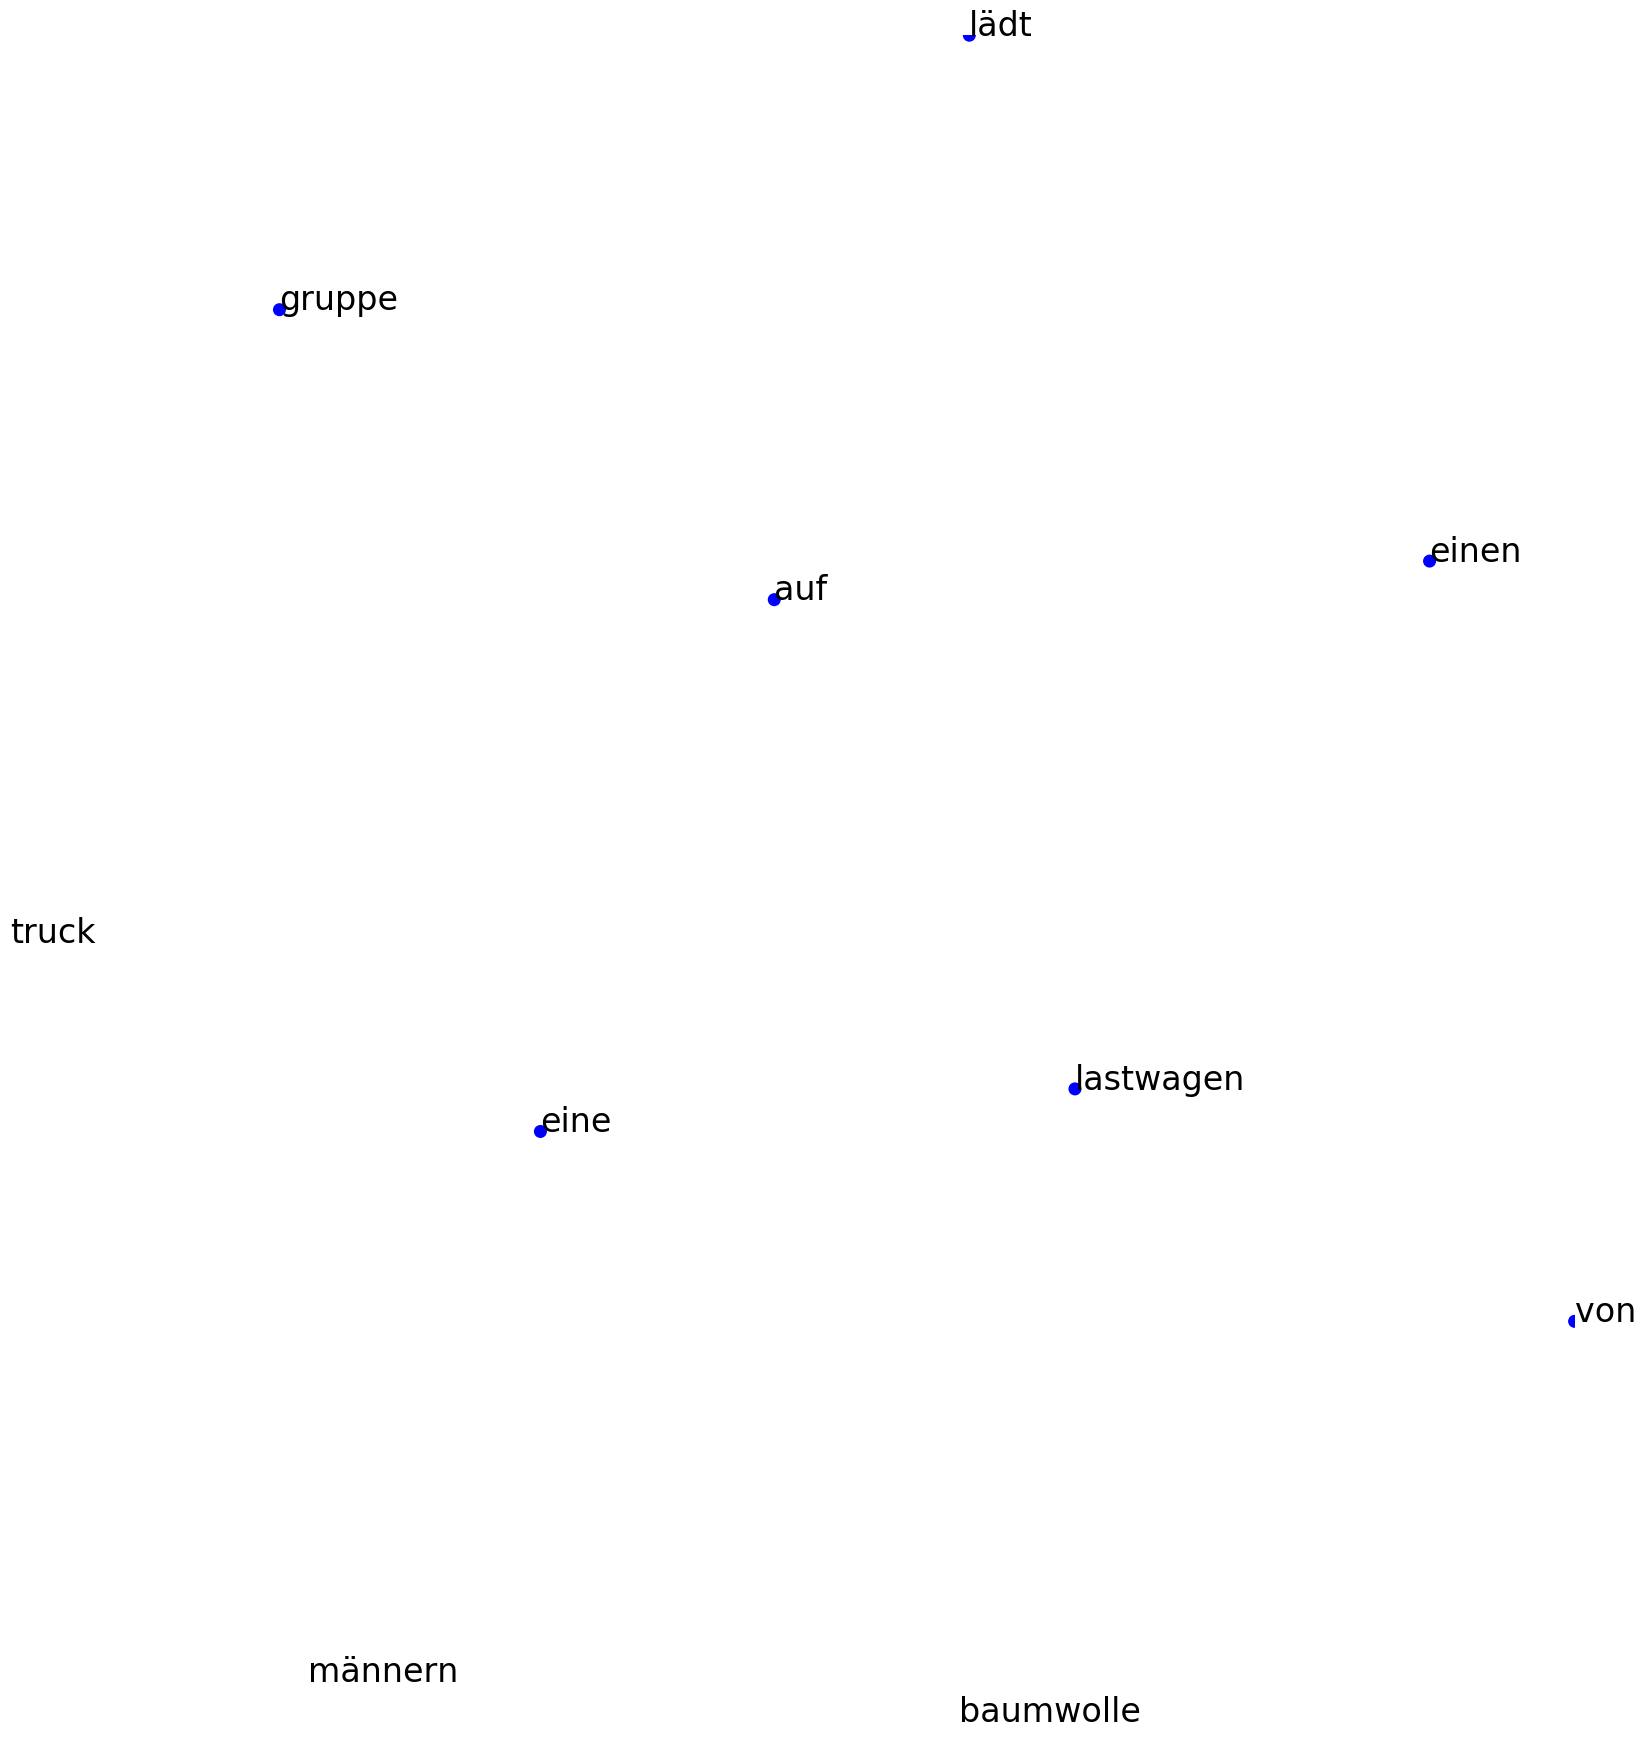

In [44]:
    
de_raw_sentence = des[sample_id].strip()
en_raw_sentence = ens[sample_id].strip()


en = tokenizer.tokenize(ens[sample_id])
de = tokenizer.tokenize(des[sample_id])
# for s in en:
#     print(model[s])
# for s in de:
#     print(model[s])
print(en)
print(de)
arg = 3
sim_type = 1 # 1 or 2
similarity_total = np.array([0. for i in range(len(de_raw_sentence.split()))])

from copy import copy
# tsne("look", 30)
print(en)
print(de)
print(de_raw_sentence)

## seperated sentence embedding
# en_sentence_embed = embedder.encode(en_raw_sentence, output_value = 'token_embeddings')[0][1:-1]
# en_sentence_embed = [en_sentence_embed[i] for i in range(en_sentence_embed.shape[0])]

# de_sentence_embed = embedder.encode(de_raw_sentence, output_value = 'token_embeddings')[0][1:-1]
# de_sentence_embed = [de_sentence_embed[i] for i in range(de_sentence_embed.shape[0])]



## joint sentence embedding
en_de = en_raw_sentence + ' ' + de_raw_sentence#+ ' [CLS] ' + de_raw_sentence
print(tokenizer.tokenize(en_de))
print(en_raw_sentence + ' ' + de_raw_sentence)

en_de_embed = embedder.encode(en_de, output_value = 'token_embeddings')[0][1:-1]
en_de_embed = [en_de_embed[i] for i in range(en_de_embed.shape[0])]
en_sentence_embed = en_de_embed[:len(en)]
de_sentence_embed = en_de_embed[len(en):]
assert len(en_de_embed)==len(en)+len(de), (len(en_de_embed), len(en)+len(de))

for arg in range(len(en_raw_sentence.split())):
    de_alignment, de_alignment_dict = get_alignment(de_raw_sentence)
    similarity, alignment_de_embeds = compute_word2word_similarity_by_alignment(de_raw_sentence, de_alignment_dict, de_sentence_embed, \
                                                                                en_sentence_embed, sim_type=sim_type, arg=arg)
    # print('\n============== The word to match: ', en[arg], '======================')
    # for a, b in zip(de_raw_sentence.split(), similarity):
    #     print(a, '\t',  b)
    similarity_total += np.array(similarity)
    
for a, b in zip(de_raw_sentence.split(), similarity_total.tolist()):
    print(a, '\t',  b)
print(similarity_total)


## sentence-level embedding
alignment_sentence_embeds = [copy(en_sentence_embed[arg])]
alignment_sentence_embeds.extend(alignment_de_embeds)
tsne(en[arg], None, de_raw_sentence.split(), wordvectors=alignment_sentence_embeds)


============== The word to match:  a ======================
eine 	 0.6333350539207458
gruppe 	 0.5203052163124084
von 	 0.8959910273551941
män 	 1.0000001192092896
##nern 	 0.9999999403953552
l 	 0.413483589887619
##ä 	 0.48790937662124634
##dt 	 0.33076220750808716
ba 	 0.48206827044487
##um 	 0.40971022844314575
##wo 	 0.451668381690979
##lle 	 0.47377631068229675
auf 	 0.5035742521286011
einen 	 0.4464268982410431
last 	 0.2939488887786865
##wagen 	 0.29394885897636414

============== The word to match:  group ======================
eine 	 0.6333350539207458
gruppe 	 0.5203052163124084
von 	 0.8959910273551941
män 	 1.0000001192092896
##nern 	 0.9999999403953552
l 	 0.413483589887619
##ä 	 0.48790937662124634
##dt 	 0.33076220750808716
ba 	 0.48206827044487
##um 	 0.40971022844314575
##wo 	 0.451668381690979
##lle 	 0.47377631068229675
auf 	 0.5035742521286011
einen 	 0.4464268982410431
last 	 0.2939488887786865
##wagen 	 0.29394885897636414

============== The word to match:  of =

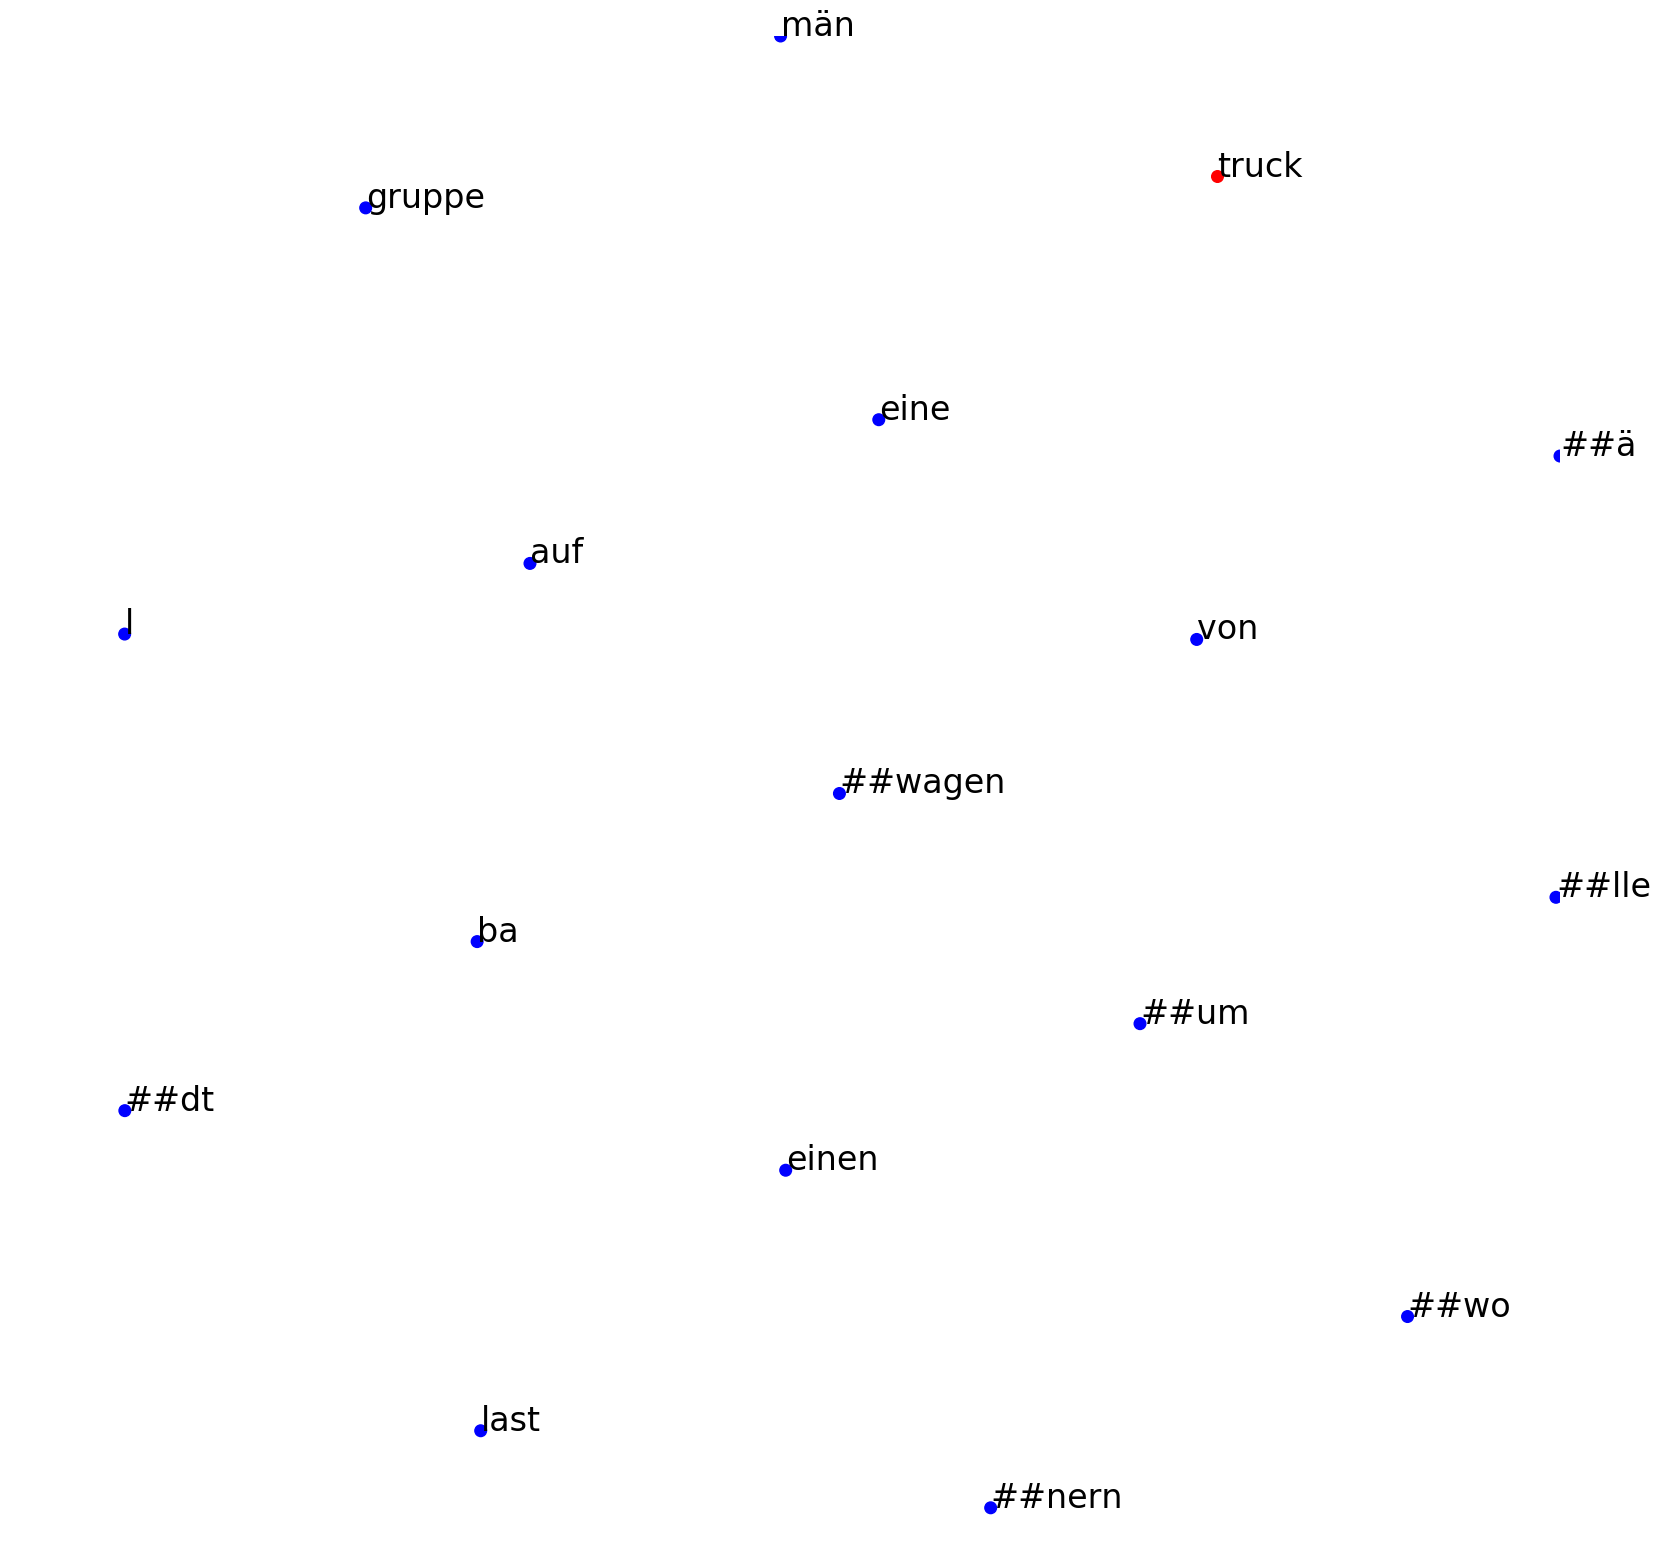

In [87]:
## unaligned word-level tsne

de_alignment = [i for i in range(len(de))]
de_alignment_dict = Counter(de_alignment)

similarity_total = np.array([0. for i in range(len(de))])
for arg in range(len(en)):
    similarity, alignment_de_embeds = compute_word2word_similarity_by_alignment(' '.join(de), de_alignment_dict, de_sentence_embed, \
                                                                            de_sentence_embed, sim_type=sim_type)
    print('\n============== The word to match: ', en[arg], '======================')
    for a, b in zip(de, similarity):
        print(a, '\t',  b)
    similarity_total += np.array(similarity)
    
for a, b in zip(de, similarity_total.tolist()):
    print(a, '\t',  b)
print(similarity_total)

    
## unaligned word-level tsne
alignment_sentence_embeds = [copy(en_sentence_embed[arg])]
alignment_sentence_embeds.extend(alignment_de_embeds)
print(len(alignment_sentence_embeds))
tsne(en[arg], None, de, wordvectors=alignment_sentence_embeds)

# draw word-level bert embedding similarity

In [53]:
from copy import copy
# tsne("look", 30)
print(en)
print(de)
de_raw_sentence = des[0]
print(de_raw_sentence)

## sentence embedding
arg = -1
en_sentence_embed = model[en[arg]]
de_sentence_embed = [model[word] for word in de]
sentence_embed = [en_sentence_embed]
sentence_embed.extend(de_sentence_embed)

en_de = en + ['[CLS]'] + de
en_de_embed = embedder.encode(en_de)
en_sentence_embed = en_de_embed[:len(en)]
de_sentence_embed = en_de_embed[len(en)+1:]
assert len(en_de_embed), len(en_de)

['a', 'group', 'of', 'men', 'are', 'loading', 'cotton', 'onto', 'a', 'truck']
['eine', 'gruppe', 'von', 'män', '##nern', 'l', '##ä', '##dt', 'ba', '##um', '##wo', '##lle', 'auf', 'einen', 'last', '##wagen']
eine gruppe von männern lädt baumwolle auf einen lastwagen



NameError: name 'model' is not defined

truck
eine 	 0.041927215
gruppe 	 0.034958843
von 	 0.0576475
männern 	 0.051015455
lädt 	 0.122506544
baumwolle 	 0.0875709
auf 	 0.12099419
einen 	 0.15330149
lastwagen 	 0.19737245
10


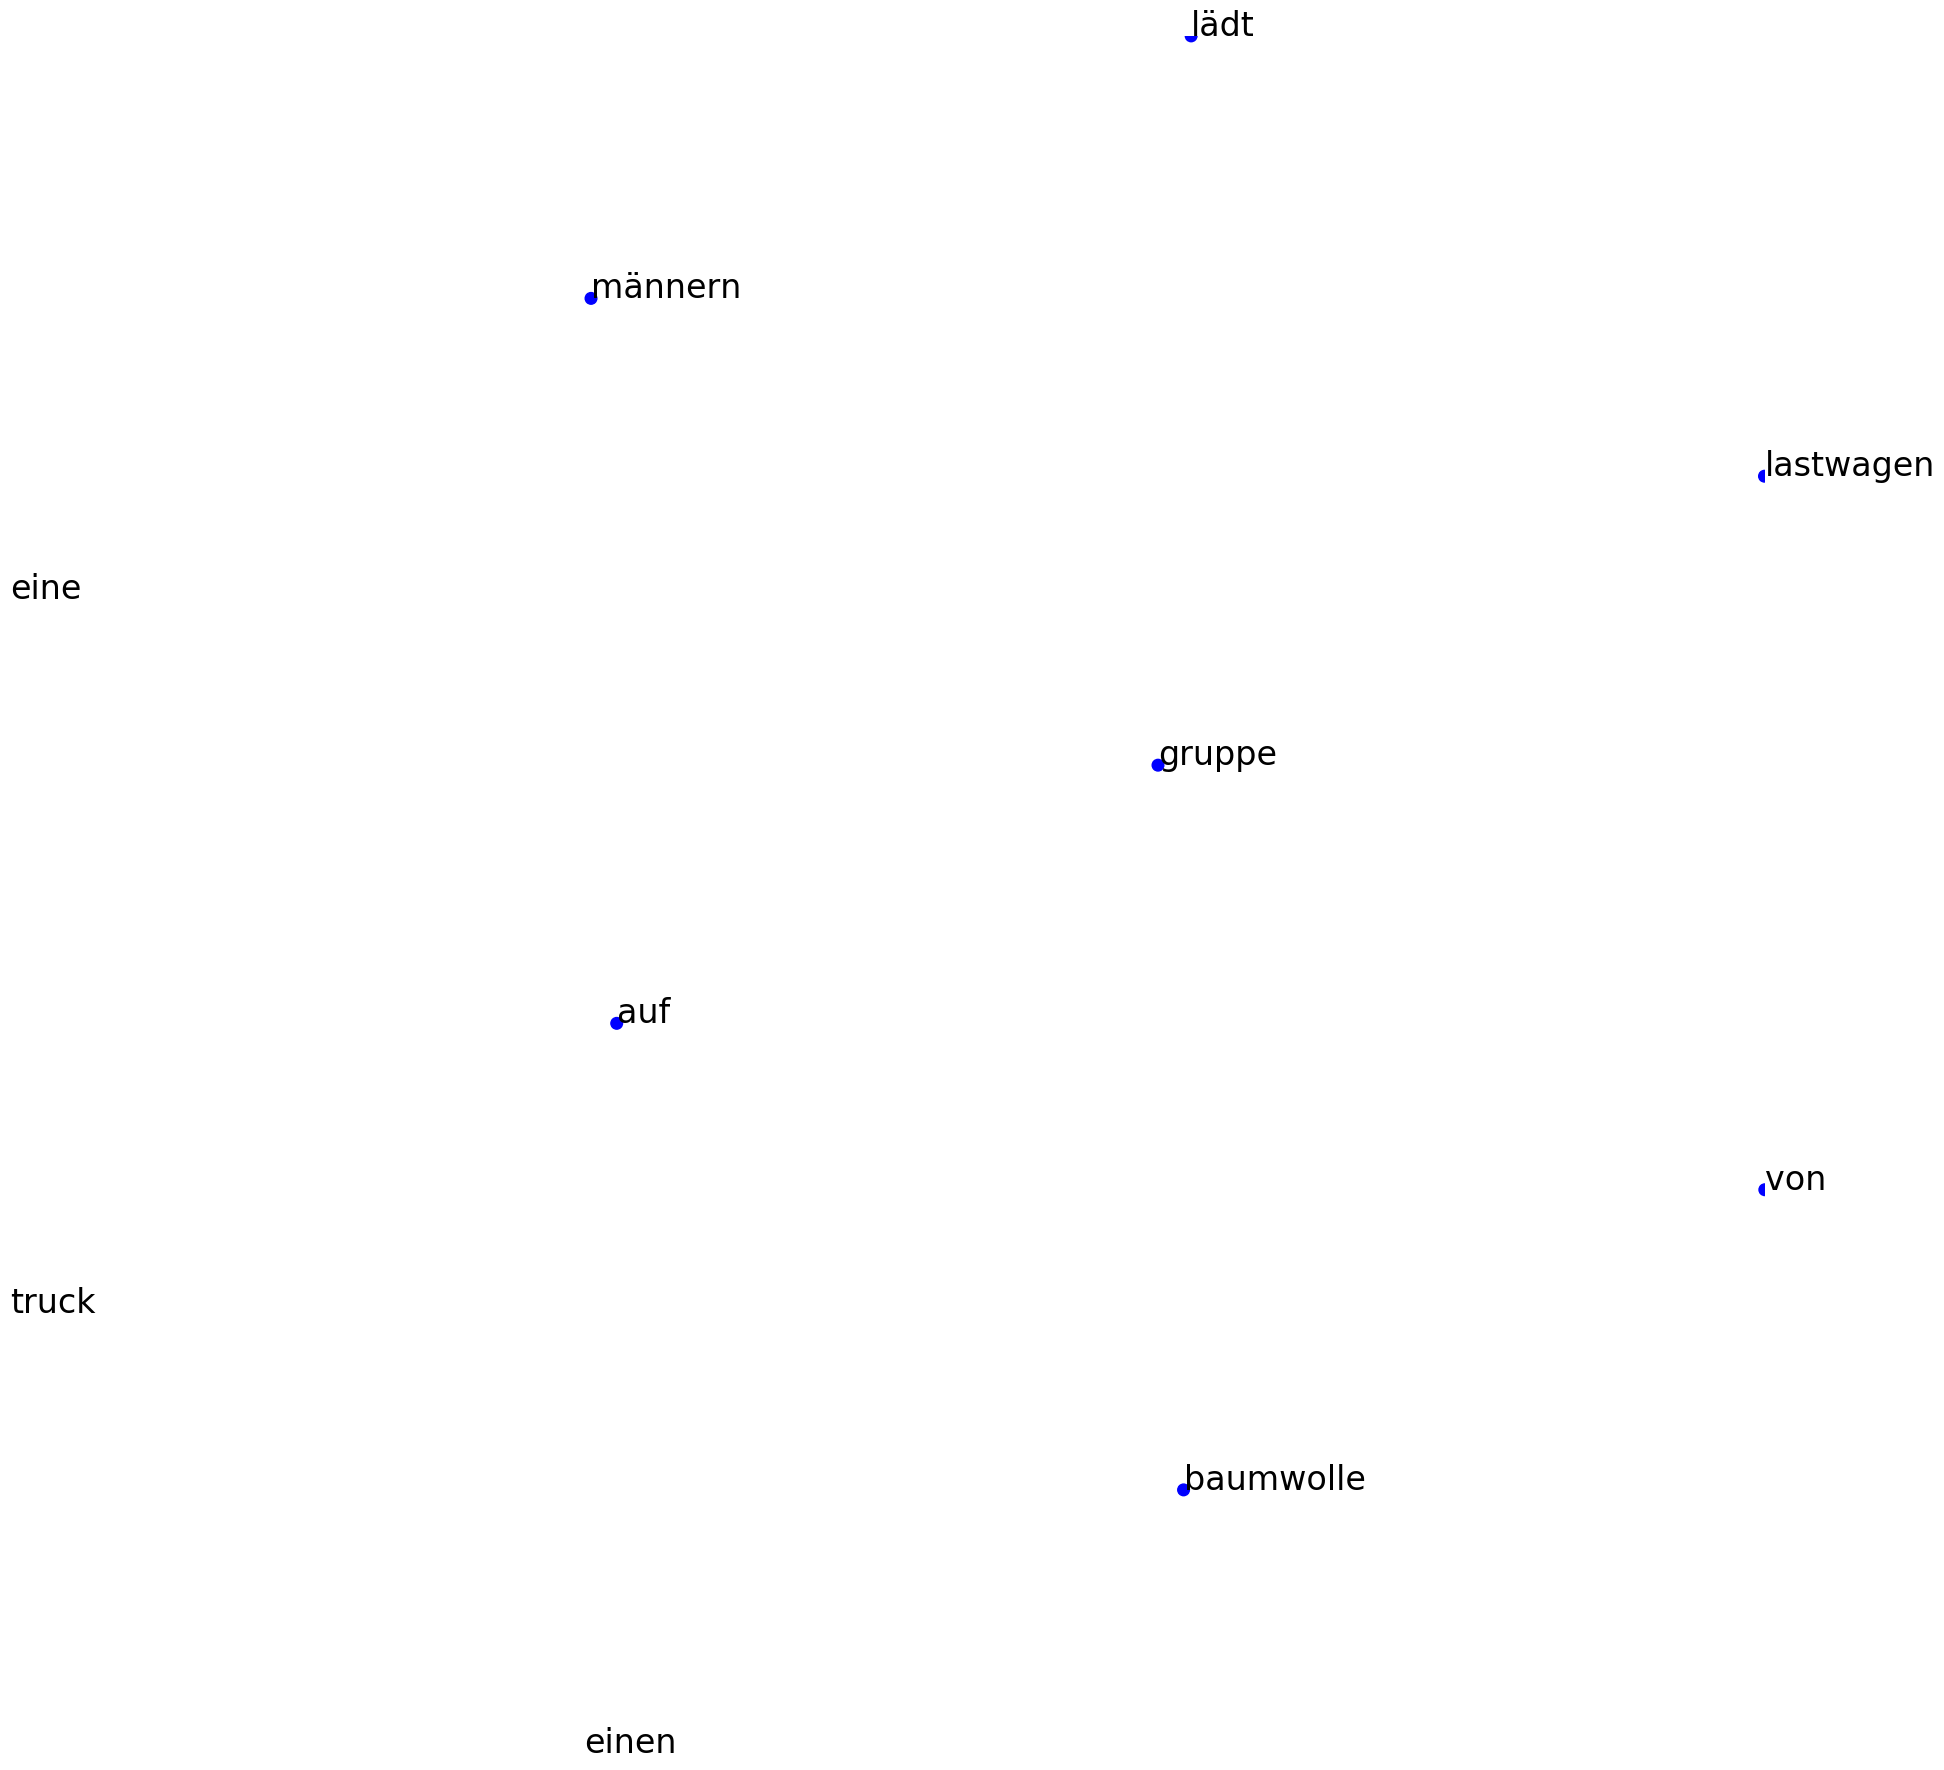

In [54]:
## aligned word-level tsne
print(en[arg])

de_alignment, de_alignment_dict = get_alignment(de_raw_sentence)
similarity, alignment_de_embeds = compute_word2word_similarity_by_alignment(de_raw_sentence, de_alignment_dict, de_sentence_embed, \
                                                                            en_sentence_embed, sim_type=sim_type)
for a, b in zip(de_raw_sentence.split(), similarity):
    print(a, '\t',  b)


## aligned word-level embedding
alignment_sentence_embeds = [copy(en_sentence_embed[arg])]
alignment_sentence_embeds.extend(alignment_de_embeds)
print(len(alignment_sentence_embeds))
tsne(en[arg], None, de_raw_sentence.split(), wordvectors=alignment_sentence_embeds)




eine 	 0.3732260763645172
gruppe 	 0.3207557201385498
von 	 0.39549651741981506
män 	 0.2866056561470032
##nern 	 0.29394882917404175
l 	 0.6238848567008972
##ä 	 0.5988156795501709
##dt 	 0.5733951926231384
ba 	 0.46344584226608276
##um 	 0.38918042182922363
##wo 	 0.42683327198028564
##lle 	 0.47160831093788147
auf 	 0.7616938352584839
einen 	 0.8493745923042297
last 	 0.9905813336372375
##wagen 	 1.0
17


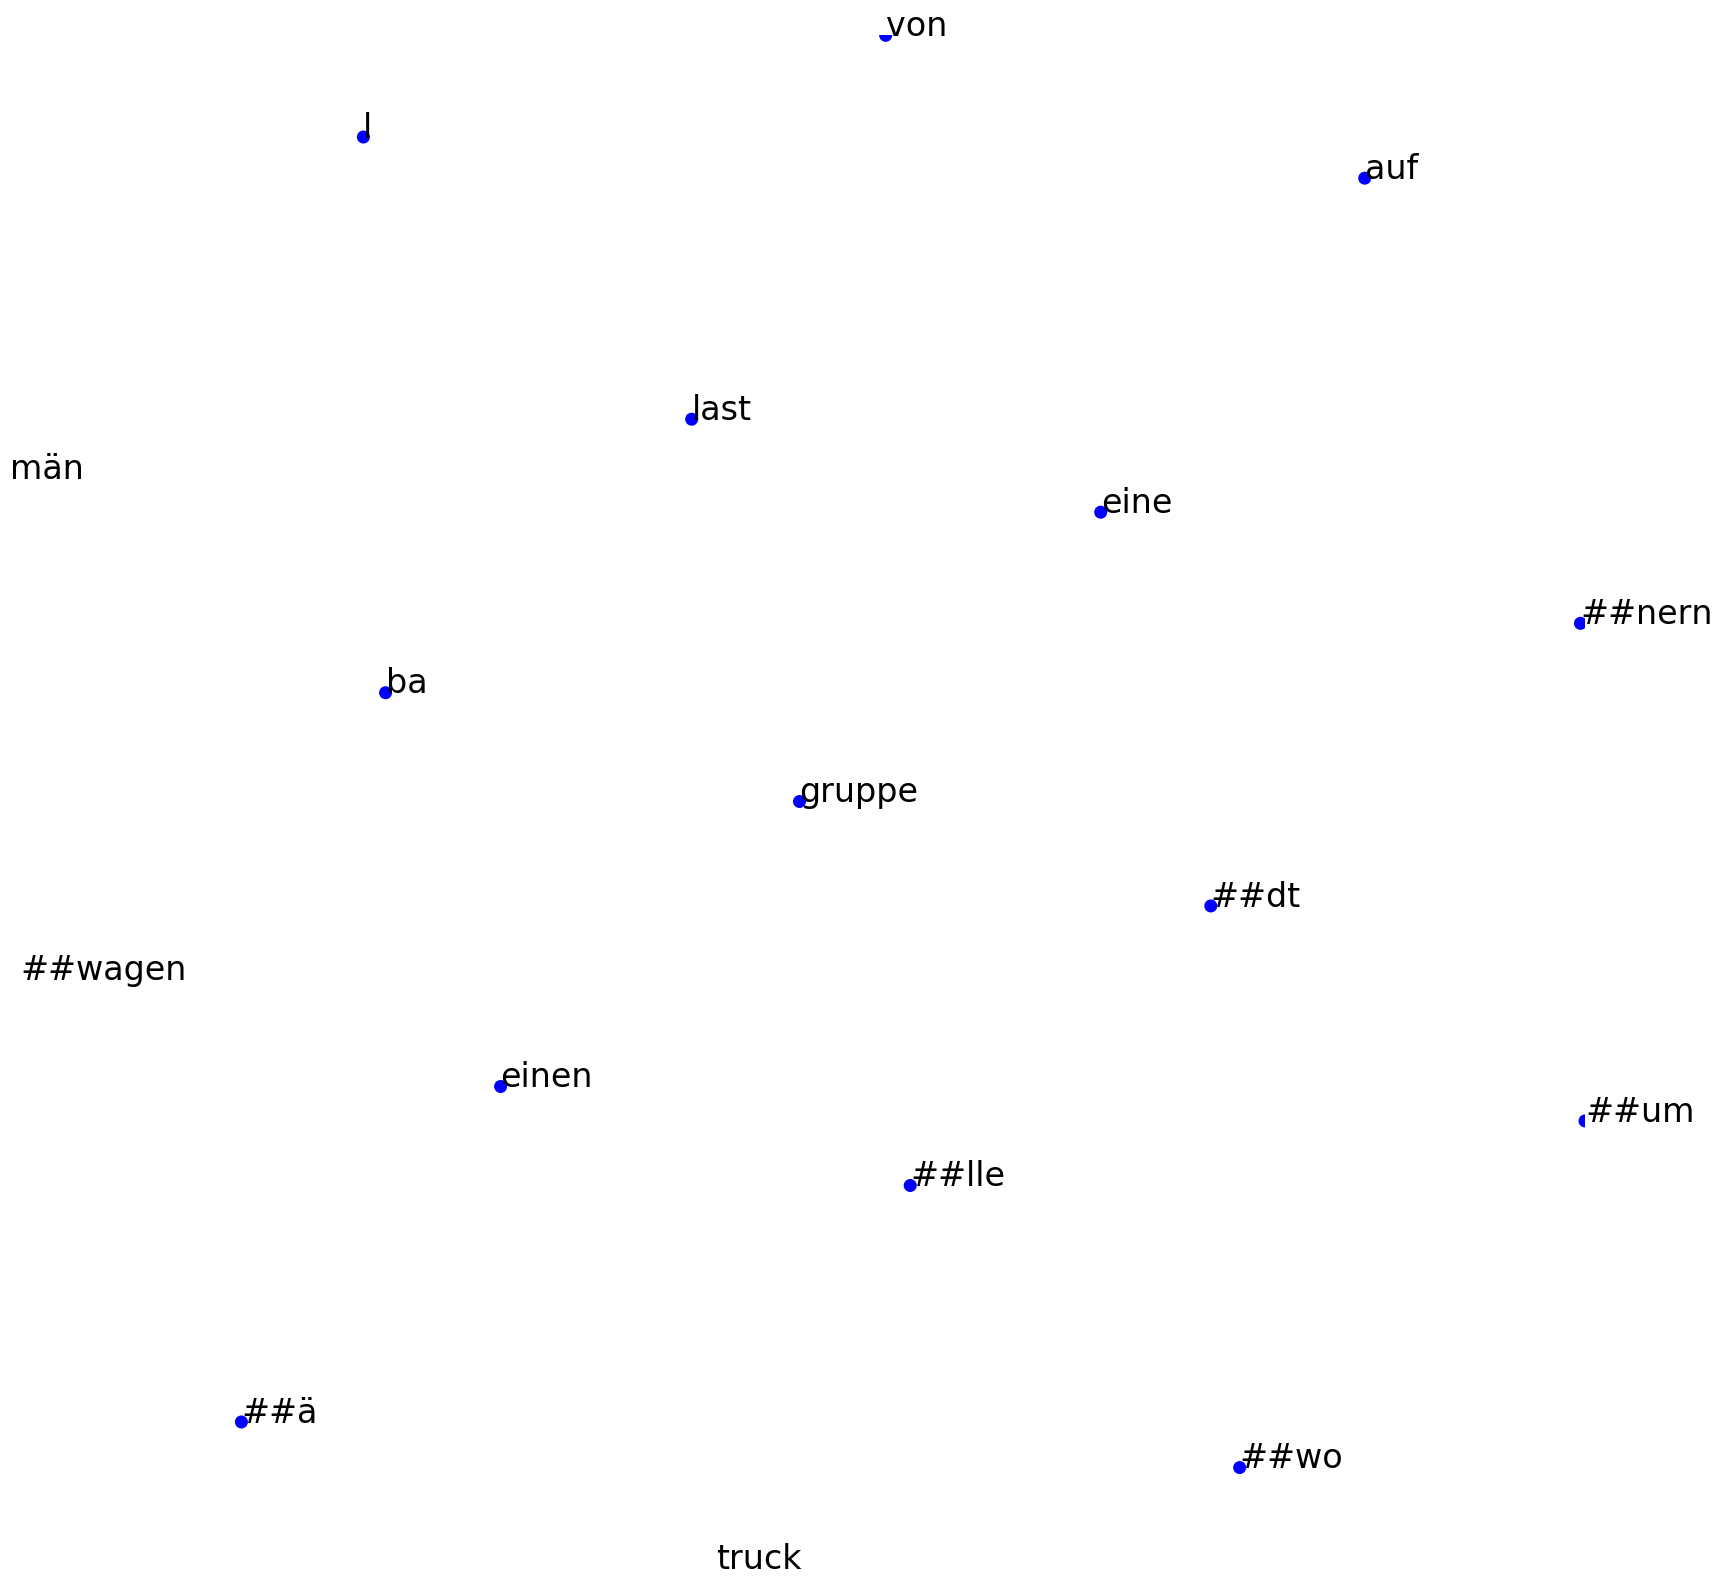

In [27]:
## unaligned word-level tsne
de_alignment = [i for i in range(len(de))]
de_alignment_dict = Counter(de_alignment)
similarity, alignment_de_embeds = compute_word2word_similarity_by_alignment(' '.join(de), de_alignment_dict, de_sentence_embed, \
                                                                            de_sentence_embed, sim_type=sim_type)
for a, b in zip(de, similarity):
    print(a, '\t',  b)
## unaligned word-level tsne
alignment_sentence_embeds = [copy(en_sentence_embed[arg])]
alignment_sentence_embeds.extend(alignment_de_embeds)
print(len(alignment_sentence_embeds))
tsne(en[arg], None, de, wordvectors=alignment_sentence_embeds)

In [ ]:
tsne("##go", 30)

In [9]:
## 根据词向量，计算bottom-up-attention提取的object和实际source sentence的object的相关程度，保存在指定文件中。
splits = ['train']#['val', 'train']
import json
for split in splits:

    image_lists_file = '/home/dxwang/code/MMT/A-Visual-Attention-Grounding-Neural-Model/data/Multi30K_DE/%s_images.txt' % split
    with open(image_lists_file, 'r') as f: image_lists = [l.strip() for l in f.readlines()]

    json_file = '/home/dxwang/code/MMT/A-Visual-Attention-Grounding-Neural-Model/data/'+split+'.json'
    # [u'obj_boxes', u'features', u'obj_confs', u'image_name', u'boxes', u'obj_categories']
    with open(json_file, 'r') as f: items = [json.loads(s) for s in f]

    def clean_obj(obj_list):
        if isinstance(obj_list, str): obj_list = obj_list.split()
        for w in ['a', 'two', '2', 'one', 'eight', '8', 'three', '1', '3', '4', 'four']:
            if w in obj_list: obj_list.remove(w)
        w = ' '.join(obj_list)
        w = w.replace(',', '')
        w = w.replace('a group of ', '')
#         for p in ['boy', 'people', 'lady', 'man', 'men']:
#             w = w.replace(p, 'person')
        return w

    ## only the train/dev set has relative_obj.en
    relative_obj_file = '/home/dxwang/code/MMT/A-Visual-Attention-Grounding-Neural-Model/data/%s_relative_obj.en' % split
    with open(relative_obj_file, 'r') as f: relative_objs = [l.strip().split('||') for l in f.readlines()]
    
    detection_sim_file = '/home/dxwang/code/MMT/A-Visual-Attention-Grounding-Neural-Model/data/%s_obj_similarity_fake' % split
    
    with open(detection_sim_file, 'w') as f:
        for i, it in enumerate(items):
            if i % 500 == 0: print(i)
            assert it['image_name'].split('/')[-1] == image_lists[i], (it['image_name'], image_lists[i])
            detect_results = it['obj_categories']
            detect_results = [w.split()[-1] for w in detect_results]
            
            relative_obj = relative_objs[i]
            relative_obj = list(set(' '.join(relative_obj).split()))
            for w in [
                'a', 'an', ',', 'one', 'of', 'two', '2', 'three', 'eight', '8', '1', '3', '4', 'four', 'six',
                'several', 'group', 'many', 'five', 'the', 'it', 'that', 'or', 'and', 'there', 'here', 'their',
                'some', 'on', 'in', '4\'', 'last', 'who', 'us', 'her', 'his', 'first', 'what',
                ]:
                if w in relative_obj: relative_obj.remove(w)

                    
#             print(relative_obj)
#             print(detect_results)
#             print('')
            

            max_sims = []
            for i, w in enumerate(detect_results):
                max_sim = 0.
                w = clean_obj(str(w))
                w_em = get_embedding(w, embedding_type)
                for o in relative_obj:
                    o = clean_obj(str(o))
                    o_em = get_embedding(o, embedding_type)
                    # print(w, o, 1.-cosine_distance(w_em, o_em))
                    max_sim = max(max_sim, round(float(1.-cosine_distance(w_em, o_em)),2))
                # print(w, max_sim)
                max_sims.append(str(max_sim))
            f.write(' '.join(max_sims) + '\n')
print('done')

0
500
1000
1500
2000
2500
3000
3500
4000
4500
5000
5500
6000
6500
7000
7500
8000
8500
9000
9500
10000
10500
11000
11500
12000
12500
13000
13500
14000
14500
15000
15500
16000
16500
17000
17500
18000
18500
19000
19500
20000
20500
21000
21500
22000
22500
23000
23500
24000
24500
25000
25500
26000
26500
27000
27500
28000
28500
done
